라이브러리 불러오기

In [ ]:
!pip install pandas-datareader
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 6.3MB 7.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=24d678df316499f2220b2345b4e5c7044c4d32e117815b17db3ef8256db7b6a7
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 256kB 30.4MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import FinanceDataReader as fdr
from pykrx import stock

import warnings 
warnings.filterwarnings('ignore')

### 공통함수

종목코드 검색 함수

In [ ]:
def my_ticker(names):    
    df_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
    df_code.종목코드 = df_code.종목코드.map('{:06d}'.format)

    df_code = df_code[['회사명', '종목코드']]
    code_list = []
    for name in names:
        code = df_code.query("회사명=='{}'".format(name))['종목코드'].to_string(index=False)
        code = code.split(' ')[1]
        code_list.append(code)
    return code_list

In [ ]:
def my_krx(start, end, *codes):
    df = pd.DataFrame()
    for code in codes:
        krx_df = stock.get_market_ohlcv_by_date('20100101', '20191231', stock_code[i])
        krx_df.reset_index(inplace=True)
        krx_df.insert(loc=1, column='종목코드', value=stock_code[i])
        krx_df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
    return df

In [ ]:
stocks = ['삼성전자', 'SK하이닉스', '현대자동차', 'NAVER']
stock_code= my_ticker(stocks)
print(tickers)

['005930', '000660', '005380', '035420']


In [ ]:
krx_df = pd.DataFrame()
df = pd.DataFrame()
for i, sname in enumerate(stocks):
  krx_df = stock.get_market_ohlcv_by_date('20100101', '20191231', stock_code[i])
  krx_df.reset_index(inplace=True)
  krx_df.insert(loc=1, column='종목코드', value=stock_code[i])
  krx_df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
  df[sname]= krx_df['close']



In [ ]:
df

,삼성전자,SK하이닉스,현대자동차,NAVER
0,16180,24100,119000,60583
1,16440,23350,110000,60583
2,16820,24550,111000,60269
3,16260,24400,106000,60426
4,16420,24650,106000,58386
...,...,...,...,...
2461,55500,94600,122500,184000
2462,55000,93800,122000,182000
2463,55400,94800,122500,180500
2464,56500,96000,120500,183500


In [ ]:
#이동평균가
temp = df[['삼성전자','SK하이닉스']].copy()
temp['어제shift(1)'] = df['SK하이닉스'].shift(1)
temp['변동가'] =   df['SK하이닉스'] - temp['어제shift(1)'] 
temp['어제pct_ch()'] = df['SK하이닉스'].pct_change(-1) #변동률
temp['이동평균가(rolling)'] = df['SK하이닉스'].rolling(2).mean()
temp.head()


,삼성전자,SK하이닉스,어제shift(1),변동가,어제pct_ch(),이동평균가(rolling)
0,16180,24100,NaN,NaN,0.032120,NaN
1,16440,23350,24100.0,-750.0,-0.048880,23725.0
2,16820,24550,23350.0,1200.0,0.006148,23950.0
3,16260,24400,24550.0,-150.0,-0.010142,24475.0
4,16420,24650,24400.0,250.0,0.027083,24525.0


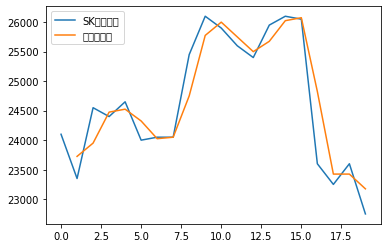

In [ ]:
plt.plot(temp['SK하이닉스'].iloc[:20], label='SK하이닉스')
plt.plot(temp['이동평균가(rolling)'].iloc[:20], label='이동평균선')
plt.legend()

## 자산배분 투자 - 기대수익률과 위험 측정

ref : "https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=anthouse28&logNo=221640874003"

In [ ]:
# 각 주식의 수익률 ln(종가/1일전종가)
dflog = np.log(df/df.shift(1)).dropna()
dflog.head()

,삼성전자,SK하이닉스,현대자동차,NAVER
1,0.015941,-0.031615,-0.078643,0.000000
2,0.022851,0.050115,0.009050,-0.005196
3,-0.033861,-0.006129,-0.046091,0.002602
4,0.009792,0.010194,0.000000,-0.034343
5,-0.029668,-0.026723,-0.043380,-0.013536


In [ ]:
# 연간 기대수익률
dflog.mean()*252

삼성전자      0.126562
SK하이닉스    0.139254
현대자동차     0.001281
NAVER     0.114951
dtype: float64

# 투자의 가장 효율적인 배분은?
- 포트폴리오 최적화
- 리스크를 낮추면서 수익률이 높은 경우 찾기

### 리스크
* 변동성 =  분산(기대(평균)수익률로부터 +- 변동성)
* 변동성 크다  => 리스크가 크다
* 공분산, 편차


In [ ]:
#각 주식의 변동성
stddf = dflog.std()
year_std = stddf*np.sqrt(252)
print(year_std)

삼성전자      0.268497
SK하이닉스    0.379076
현대자동차     0.312276
NAVER     0.350546
dtype: float64


In [ ]:
#두 주식의 공분산 행렬 
day_cov = dflog.cov()
year_cov = day_cov*252
print(year_cov)

            삼성전자    SK하이닉스     현대자동차     NAVER
삼성전자    0.072091  0.047507  0.020093  0.016949
SK하이닉스  0.047507  0.143698  0.024705  0.016012
현대자동차   0.020093  0.024705  0.097517  0.011607
NAVER   0.016949  0.016012  0.011607  0.122882


## 효율적 투자선
- 수익 대비 리스크가 어느정도인가

In [ ]:
stocks = dflog.columns
y_risks = dflog[stocks].cov()*252
y_returns = dflog[stocks].mean()*252

In [ ]:
y_returns

삼성전자      0.126562
SK하이닉스    0.139254
현대자동차     0.001281
NAVER     0.114951
dtype: float64

### 수익률, 리스크 계산

In [ ]:
risk_list = []
return_list = []
w_list= []
np.random.seed(121)
for i in range(10000):
  w = np.random.random(len(stocks))
  w = w / np.sum(w)
  expected_return =np.sum(y_returns*w)  #np.dot(w.T, y_returns) 
  expected_risk = np.sqrt(np.dot(w.T, np.dot(y_risks, w)))
  w_list.append(w)
  return_list.append(expected_return)
  risk_list.append(expected_risk)
  

port_df = pd.DataFrame({"수익률": return_list, 
                        "리스크": risk_list})

for i in range(len(stocks)):
  port_df["w_"+str(i)] = np.array(w_list)[:,i]

In [ ]:
port_df

,수익률,리스크,w_0,w_1,w_2,w_3
0,0.086569,0.216941,0.157468,0.298113,0.329506,0.214913
1,0.097772,0.206234,0.326917,0.160635,0.218866,0.293581
2,0.084171,0.227280,0.093432,0.364200,0.358193,0.184175
3,0.101829,0.241682,0.009613,0.450585,0.212754,0.327047
4,0.105812,0.233553,0.134390,0.422949,0.184549,0.258113
...,...,...,...,...,...,...
9995,0.073960,0.224538,0.085176,0.302664,0.434026,0.178134
9996,0.081065,0.204166,0.312242,0.078411,0.346764,0.262583
9997,0.105749,0.224504,0.368714,0.323172,0.187707,0.120407
9998,0.080263,0.206151,0.332667,0.019842,0.343388,0.304102


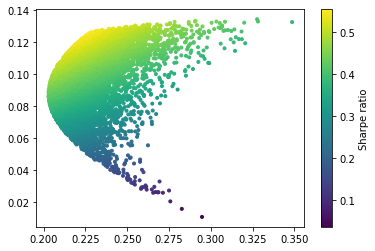

In [ ]:
plt.scatter(port_df['리스크'], port_df['수익률'],
            c= port_df['수익률']/port_df['리스크'],marker= '.')

plt.colorbar(label = 'Sharpe ratio')

### 샤프지수
- 샤프지수 = (포트폴리오 기대수익률- 무위험자산 수익률)/ 포트폴리오 수익률의 표준편차

In [ ]:
샤프지수 = port_df['수익률']/ port_df['리스크']

In [ ]:
# 최대수익률
port_df.iloc[샤프지수[샤프지수== max(샤프지수)].index,:]

,수익률,리스크,w_0,w_1,w_2,w_3
1679,0.126056,0.227838,0.51827,0.220631,0.002418,0.258681
